In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('../..')
from src import utils

In [2]:
DATA        = Path('data')
RAW         = DATA/'raw'
INTERIM     = DATA/'interim'
PROCESSED   = DATA/'processed'
SUBMISSIONS = DATA/'submissions'

In [3]:
from src.utils import get_weeks
# week_labels = get_weeks(day_from=20160104, num_weeks=121)[52:]
# week_labels = get_weeks(day_from=20160104, num_weeks=121)[96:]
week_labels = get_weeks(day_from=20160104, num_weeks=121)[104:]

In [4]:
print(week_labels)

[20180101, 20180108, 20180115, 20180122, 20180129, 20180205, 20180212, 20180219, 20180226, 20180305, 20180312, 20180319, 20180326, 20180402, 20180409, 20180416, 20180423]


In [5]:
%%time
train = pd.DataFrame()
for name in week_labels[:-2]:
    train = pd.concat([train, pd.read_feather(PROCESSED/f'SVD_17-18_72f/week_{name}_SVD_diffscount.feather')])
val = pd.read_feather(PROCESSED/f'SVD_17-18_72f/week_{week_labels[-2]}_SVD_diffscount.feather')
test = pd.read_feather(PROCESSED/f'SVD_17-18_72f/week_{week_labels[-1]}_SVD_diffscount.feather')

CPU times: user 1min 26s, sys: 45.7 s, total: 2min 12s
Wall time: 2min 27s


## Fill nan

In [6]:
%%time
nan_cols = ['Subsector', 'IndustrySector', 'IndustrySubgroup', 'MarketIssue']
train.fillna({x: '-999' for x in nan_cols}, inplace=True)
val.fillna({x: '-999' for x in nan_cols}, inplace=True)
test.fillna({x: '-999' for x in nan_cols}, inplace=True)

CPU times: user 6.19 s, sys: 2.57 s, total: 8.76 s
Wall time: 8.77 s


## Preprocessing

In [8]:
cat_cols = ['BuySell', 'Sector', 'Subsector', 'Region_x', 'Country', 
            'TickerIdx', 'Seniority', 'Currency', 'ActivityGroup', 
            'Region_y', 'Activity', 'RiskCaptain', 'Owner', 
            'IndustrySector', 'IndustrySubgroup', 'MarketIssue', 'CouponType']
id_cols = ['TradeDateKey', 'CustomerIdx', 'IsinIdx']
target_col = 'CustomerInterest'
pred_col = 'PredictionIdx'
# with open(INTERIM/'num_cols.pkl', 'rb') as f:
#     num_cols = pickle.load(f)
num_cols = [c for c in train.columns \
              if c not in id_cols + cat_cols and c != target_col]

### Label encode cat cols

In [9]:
%%time
# Label encode cats
from src.utils import to_cat_codes, apply_cats
to_cat_codes(train, cat_cols)
apply_cats(val, train)
apply_cats(test, train)

for col in cat_cols:
    train[col] = train[col].cat.codes
    val[col] = val[col].cat.codes
    test[col] = test[col].cat.codes

CPU times: user 23.8 s, sys: 5.16 s, total: 28.9 s
Wall time: 29 s


In [10]:
# Val has 1 OOF 
train['TickerIdx'] = train.TickerIdx + 1
val['TickerIdx'] = val.TickerIdx + 1
test['TickerIdx'] = test.TickerIdx + 1

### Scale num cols

In [11]:
%%time
# Scale conts
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(pd.concat([train[num_cols], 
                                         val[num_cols], test[num_cols]]))

CPU times: user 6.59 s, sys: 8.63 s, total: 15.2 s
Wall time: 15.2 s


In [21]:
import pickle
with open(INTERIM/'scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f, pickle.HIGHEST_PROTOCOL)

In [12]:
def scale_features(df, scaler, num_cols):
    scaled = scaler.transform(df[num_cols])
    for i, col in enumerate(num_cols):
        df[col] = scaled[:,i]

In [13]:
%%time
scale_features(train, scaler, num_cols)
scale_features(val, scaler, num_cols)
scale_features(test, scaler, num_cols)

CPU times: user 6.69 s, sys: 8.44 s, total: 15.1 s
Wall time: 15.1 s


In [27]:
%%time
train.reset_index(drop=True).to_feather(INTERIM/'nn_train.feather')
val.reset_index(drop=True).to_feather(INTERIM/'nn_val.feather')
test.reset_index(drop=True).to_feather(INTERIM/'nn_test.feather')

CPU times: user 4.91 s, sys: 6.05 s, total: 11 s
Wall time: 8.66 s


In [24]:
with open(INTERIM/'num_cols.pkl', 'wb') as f:
    pickle.dump(num_cols, f, pickle.HIGHEST_PROTOCOL)

In [3]:
%%time
train = pd.read_feather(INTERIM/'nn_train.feather')
val = pd.read_feather(INTERIM/'nn_val.feather')
test = pd.read_feather(INTERIM/'nn_test.feather')

## Model

In [14]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim

In [15]:
from src.neuralnet import TabularDataset
from torch.utils.data import DataLoader

In [16]:
%%time
train_ds = DataLoader(TabularDataset(train, cat_cols, num_cols, target_col), batch_size=128, shuffle=True)
val_ds = DataLoader(TabularDataset(val, cat_cols, num_cols, target_col), batch_size=128)
test_ds = DataLoader(TabularDataset(test, cat_cols, num_cols), batch_size=128)

CPU times: user 2.45 s, sys: 3.83 s, total: 6.28 s
Wall time: 6.28 s


In [31]:
%%time
import pickle
with open(INTERIM/'nn_train_ds.pkl', 'wb') as f:
    pickle.dump(train_ds, f, pickle.HIGHEST_PROTOCOL)
with open(INTERIM/'nn_val_ds.pkl', 'wb') as f:
    pickle.dump(val_ds, f, pickle.HIGHEST_PROTOCOL)
with open(INTERIM/'nn_test_ds.pkl', 'wb') as f:
    pickle.dump(test_ds, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 1.19 s, sys: 3.54 s, total: 4.73 s
Wall time: 4.95 s


In [17]:
cat_szs = [int(train[col].max() + 1) for col in cat_cols]
emb_szs = [(c, min(50, (c+1)//2)) for c in cat_szs]

In [18]:
from src.neuralnet import NeuralNet, train_model

In [19]:
USE_CUDA = True

In [20]:
model = NeuralNet(emb_szs, n_cont=len(num_cols), emb_drop=0.04, 
                  szs=[1000, 500], drops=[0.001, 0.01], use_bn=True)

In [21]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

In [23]:
%%time
model, train_losses, val_losses, val_aucs = train_model(model, optimizer, criterion, 
                                train_ds, val_ds, n_epochs=2, USE_CUDA=USE_CUDA,
                                val_every=10)

Train Epoch: 1 [102400/8102750 (1%)]	Loss: 0.166101
Train Epoch: 1 [204800/8102750 (3%)]	Loss: 0.131777
Train Epoch: 1 [307200/8102750 (4%)]	Loss: 0.131392
Train Epoch: 1 [409600/8102750 (5%)]	Loss: 0.131325
Train Epoch: 1 [512000/8102750 (6%)]	Loss: 0.133637
Train Epoch: 1 [614400/8102750 (8%)]	Loss: 0.130733
Train Epoch: 1 [716800/8102750 (9%)]	Loss: 0.131957
Train Epoch: 1 [819200/8102750 (10%)]	Loss: 0.128743
Train Epoch: 1 [921600/8102750 (11%)]	Loss: 0.128551
Train Epoch: 1 [1024000/8102750 (13%)]	Loss: 0.131090
[0/493590 (0%)]
[102400/493590 (21%)]
[204800/493590 (41%)]
[307200/493590 (62%)]
[409600/493590 (83%)]
ROC AUC Score: 0.814105
Validation Loss: 0.134310
Train Epoch: 1 [1126400/8102750 (14%)]	Loss: 0.128691
Train Epoch: 1 [1228800/8102750 (15%)]	Loss: 0.128515
Train Epoch: 1 [1331200/8102750 (16%)]	Loss: 0.125471
Train Epoch: 1 [1433600/8102750 (18%)]	Loss: 0.128571
Train Epoch: 1 [1536000/8102750 (19%)]	Loss: 0.128719
Train Epoch: 1 [1638400/8102750 (20%)]	Loss: 0.12806

In [24]:
train_losses = pd.Series(train_losses)
val_losses = pd.Series(val_losses)
val_aucs = pd.Series(val_aucs)

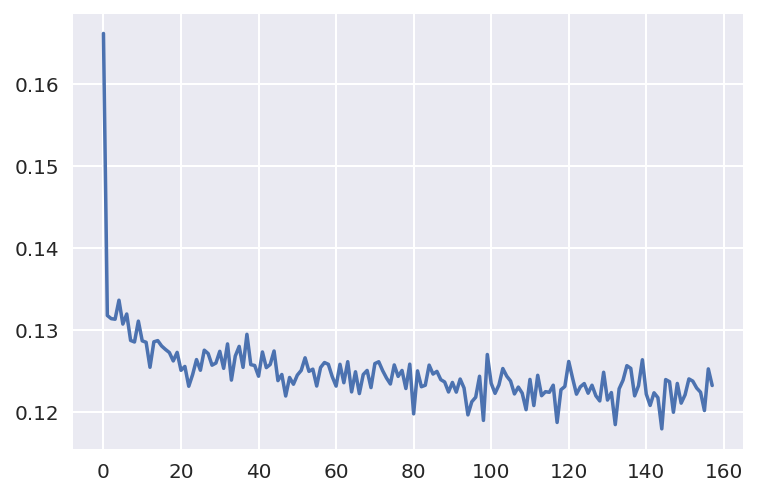

In [25]:
train_losses.plot()

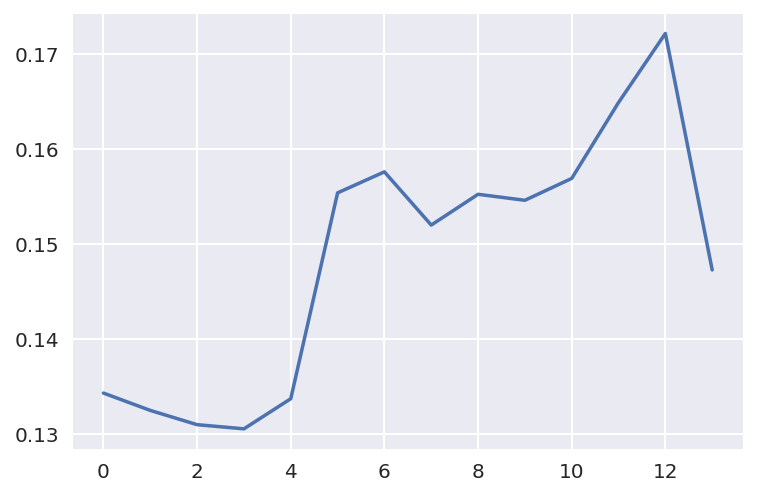

In [26]:
val_losses.plot()

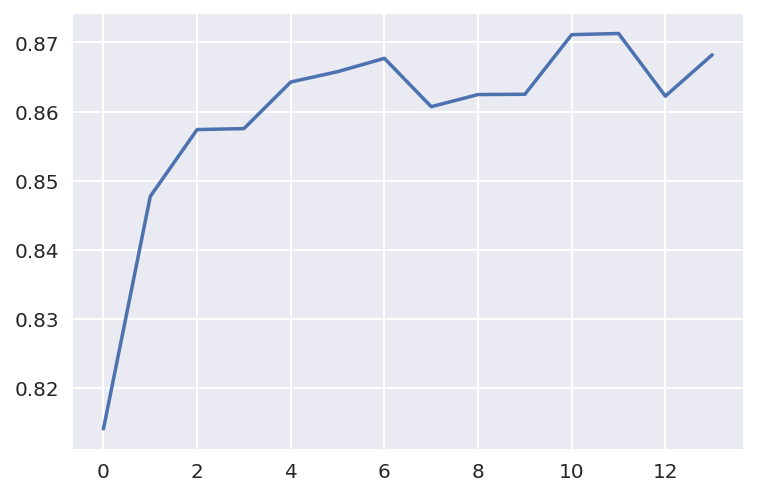

In [27]:
val_aucs.plot()

In [29]:
torch.save(model.state_dict(), INTERIM/'27_model_weights.pkl')

## All train

In [28]:
%%time
all_train_ds = DataLoader(TabularDataset(pd.concat([train, val]), cat_cols, num_cols, target_col), 
                                              batch_size=128, shuffle=True)
test_ds = DataLoader(TabularDataset(test, cat_cols, num_cols), batch_size=128)

CPU times: user 3.8 s, sys: 5.4 s, total: 9.2 s
Wall time: 9.19 s


In [30]:
model = NeuralNet(emb_szs, n_cont=len(num_cols), emb_drop=0.04, 
                  szs=[1000, 500, 500], drops=[0.001, 0.01, 0.01], 
                  use_bn=True)

In [31]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

In [32]:
%%time
model, train_losses, _, _ = train_model(model, optimizer, criterion, 
                                all_train_ds, None, n_epochs=2, 
                                USE_CUDA=USE_CUDA, val_every=10)

Train Epoch: 1 [102400/8596340 (1%)]	Loss: 0.166195
Train Epoch: 1 [204800/8596340 (2%)]	Loss: 0.133631
Train Epoch: 1 [307200/8596340 (4%)]	Loss: 0.133768
Train Epoch: 1 [409600/8596340 (5%)]	Loss: 0.130278
Train Epoch: 1 [512000/8596340 (6%)]	Loss: 0.127651
Train Epoch: 1 [614400/8596340 (7%)]	Loss: 0.131835
Train Epoch: 1 [716800/8596340 (8%)]	Loss: 0.129264
Train Epoch: 1 [819200/8596340 (10%)]	Loss: 0.129838
Train Epoch: 1 [921600/8596340 (11%)]	Loss: 0.129037
Train Epoch: 1 [1024000/8596340 (12%)]	Loss: 0.128197
Train Epoch: 1 [1126400/8596340 (13%)]	Loss: 0.126020
Train Epoch: 1 [1228800/8596340 (14%)]	Loss: 0.127563
Train Epoch: 1 [1331200/8596340 (15%)]	Loss: 0.130429
Train Epoch: 1 [1433600/8596340 (17%)]	Loss: 0.127178
Train Epoch: 1 [1536000/8596340 (18%)]	Loss: 0.124723
Train Epoch: 1 [1638400/8596340 (19%)]	Loss: 0.129105
Train Epoch: 1 [1740800/8596340 (20%)]	Loss: 0.128726
Train Epoch: 1 [1843200/8596340 (21%)]	Loss: 0.126376
Train Epoch: 1 [1945600/8596340 (23%)]	Loss:

In [42]:
torch.save(model.state_dict(), INTERIM/'27_all_train_model_weights.pkl')

In [33]:
from src.neuralnet import get_predictions

In [35]:
targets, preds = get_predictions(model, test_ds, USE_CUDA=True)

[0/484758 (0%)]
[102400/484758 (21%)]
[204800/484758 (42%)]
[307200/484758 (63%)]
[409600/484758 (84%)]


In [36]:
test[target_col] = preds

## Submission

In [37]:
submission = pd.read_csv(RAW/'sample_submission.csv', low_memory=False)
submission = pd.merge(submission[['PredictionIdx']], test[['PredictionIdx', target_col]], 
                      how='left', on='PredictionIdx')

In [38]:
submission[target_col].describe()

count    484758.000000
mean          0.015546
std           0.027218
min           0.000000
25%           0.004143
50%           0.009423
75%           0.018268
max           1.000000
Name: CustomerInterest, dtype: float64

In [39]:
submission.head()

,PredictionIdx,CustomerInterest
0,a1e0d80784,0.005458
1,c2cc6cc2a8,0.025533
2,a8e94f6344,0.002645
3,758bae1e35,0.000140
4,02ab378ee8,0.000296


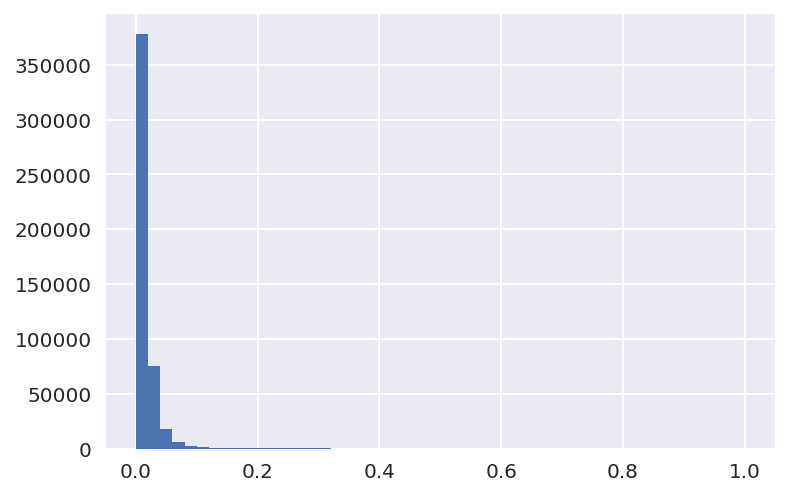

In [40]:
submission[target_col].hist(bins=50)

In [41]:
submission.to_csv(SUBMISSIONS/'RA05-26-neuralnet_alltrain_2018_scaled_SVD_diffscounts.csv', index=False)